<a href="https://colab.research.google.com/github/ramanarayanan-98/MLFall22_Lab2.2/blob/main/MLFall22_Lab_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab:  Model Order Selection for Neural Data

Machine learning is a key tool for neuroscientists to understand how sensory and motor signals are encoded in the brain.  In addition to improving our scientific understanding of neural phenomena, understanding neural encoding is critical for brain machine interfaces (see. e.g. https://www.youtube.com/watch?v=QRt8QCx3BCo).  In this lab, you will use model selection for performing some simple analysis on real neural signals.  

Before doing this lab, you should review the ideas in the polynomial model selection demo.  In addition to the concepts in that demo, you will learn to:
* Represent neural time-series data in arrays
* Load data from a pickle file
* Describe and fit memoryless linear models
* Describe and fit linear time-series models with delays
* Fit linear models with multiple target outputs
* Select the optimal delay via cross-validation

## Loading the data

The data in this lab comes from neural recordings described in:

<a href="http://jn.physiology.org/content/106/2/764.short">
Stevenson, Ian H., et al. "Statistical assessment of the stability of neural movement representations." Journal of neurophysiology 106.2 (2011): 764-774</a>

Neurons are the basic information processing units in the brain.  Neurons communicate with one another via *spikes* or *action potentials* which are brief events where voltage in the neuron rapidly rises then falls.  These spikes trigger the electro-chemical signals between one neuron and another.  In this experiment, the spikes were recorded from 196 neurons in the primary motor cortex (M1) of a monkey using an electrode array implanted onto the surface of a monkey's brain.  During the recording, the monkey performed several reaching tasks and the position and velocity of the hand was recorded as well.  

The goal of the experiment is to try to *read the monkey's brain*:  That is, predict the hand motion from the neural signals from the motor cortex.

We first load the key packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

The full data is available on the CRCNS website  http://crcns.org/data-sets/movements/dream.  This website has a large number of datasets and can be used for projects as well.  However, the raw data files can be quite large.  To make the lab easier, the [Kording lab](http://kordinglab.com/) at UPenn has put together an excellent [repository](https://github.com/KordingLab/Neural_Decoding) where they have created simple pre-processed versions of the data.  You can download the file `example_data_s1.pickle` from the [course repo](https://github.com/cpmusco/machinelearning2022/blob/master/data/example_data_s1.pickle?raw=true).  Alternatively, you can directly run the following code. 

In [2]:
fn_src = 'https://github.com/cpmusco/machinelearning2022/blob/master/data/example_data_s1.pickle?raw=true'
fn_dst = 'example_data_s1.pickle'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:        
    urllib.request.urlretrieve(fn_src, fn_dst)

File example_data_s1.pickle is already downloaded


The file is a *pickle* data structure, which is a package to serialize python objects into data files.  Once you have downloaded the file, you can run the following command to retrieve the data from the pickle file.

In [3]:
with open('example_data_s1.pickle', 'rb') as fp:
    X,y = pickle.load(fp)
X

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

The matrix `X` is matrix of spike counts where `X[i,j]` is the number of spikes from neuron `j` in time bin `i`.
The matrix `y` has two columns:
* `y[i,0] = ` velocity of the monkey's hand in the x-direction
* `y[i,1] = ` velocity of the monkey's hand in the y-direction

Our goal will be to predict **only** `y[i,0]` from `X`. We could just as easily predict movement in both directions, but this simplifies the lab.  So we reassign:

In [4]:
y = y[:,0]
y

array([ 1.51037413e-01, -1.39498351e-01, -3.55773944e-01, ...,
        3.19722904e-06,  7.24814520e-07,  9.51148351e-07])

Each time bin represent `tsamp=0.05` seconds of time.  Using `X.shape` and `y.shape` compute and print:
* `nt = ` the total number of time bins
* `nneuron = ` the total number of neurons
* `ttotal = ` total time of the experiment is seconds. 

In [5]:
tsamp = 0.05  # sampling time in seconds

nt = X.shape[0]
nneuron = X.shape[1]
ttotal = tsamp*nt
print(f"Tot time bins = {nt}, Tot neurons = {nneuron}, ttotal = {ttotal}")

Tot time bins = 61339, Tot neurons = 52, ttotal = 3066.9500000000003


## Fitting a Memoryless Linear Model

Let's first try a simple linear regression model to fit the data. 

Before doing so, we want to split the data into a training and test set. We will use a 2/3 - 1/3 split, so 1/3 of the data should be used for testing.

Let `Xtr,ytr` be the training data set and `Xts,yts` be the test data set. Recall that `ytr` and `yts` should be taken from the *first column of `y` only*. You can use any utility to perform the split that you want, but make sure that it is *random*. I.e. don't just take the first rows of the data to be the training data. `np.random.permutation` might come in handy. 

In [6]:
def splitIntoTrainAndTest(X,y):
  shuffler = np.random.permutation(len(X))
  X_shuff = X[shuffler]
  y_shuff = y[shuffler]

  nts = nt // 3
  # Testing
  Xts = X_shuff[:nts]
  yts = y_shuff[:nts]

  # Training
  Xtr = X_shuff[nts:]
  ytr = y_shuff[nts:]
  return Xtr,ytr,Xts,yts

Xtr,ytr,Xts,yts = splitIntoTrainAndTest(X,y)

Now, fit a multiple linear regression model under squared loss using `Xtr,ytr`. Make predictions  `yhat` using `Xts`.

In [7]:
def performCalculation(X,y):
  Xt = np.transpose(X)
  beta = np.linalg.inv(Xt@X)@Xt@y
  return beta

In [8]:
def createMatrix(X):
  ones = np.ones((len(X),1))
  matX = np.hstack((ones,X))
  return matX

In [9]:
beta = performCalculation(createMatrix(Xtr),ytr)
beta

array([ 0.19807272,  1.72588166,  0.233775  , -0.75989144,  0.06894876,
       -0.24692041,  1.05034234,  0.39784725,  0.08547751, -0.27412278,
        1.20470468, -0.03919257,  0.7112576 ,  0.08351714,  0.09996683,
       -2.08410513,  0.0648983 , -1.08934952,  0.49949813, -0.25063096,
        0.42825306,  0.6489315 ,  1.41712155,  1.88064694, -0.50043566,
       -0.11196315,  0.53227377, -0.12602161, -0.14236321, -0.16468036,
       -0.73298904,  0.09617447, -0.11064279, -0.40101309,  0.27540506,
       -0.70589007,  0.61281002, -1.02230837,  0.30196605, -0.31543366,
        0.49052027,  0.09696905, -0.54917776, -0.4020538 ,  0.61564312,
       -0.47721611, -0.29890894, -2.14838638,  0.11776021, -1.00437193,
       -0.1586172 , -0.65015543, -0.38635456])

In [10]:
yhat = createMatrix(Xts)@beta
yhat

array([-5.59491357, -3.22920214, -4.24726026, ...,  8.59984408,
       -2.95357818,  4.48135996])

Compare `yhat` to `yts` to measure the **averaged squared loss** (empirical risk) on the test set. Print the output. You should obtain an average loss of around 32 or 33 if you are normalizing by 1/(test set size).

In [11]:
loss = np.sum((yhat-yts)**2)/len(yts)
loss

32.23816566258111

It is useful to plot the predicted vs. true values. Plot `yhat` vs. `yts` with a scatter plot and label the axes. If the predicted values exactly matched the targets, we would expect to see a line with slope 1. 

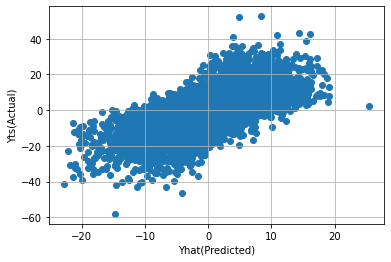

In [12]:
plt.scatter(yhat,yts)
plt.xlabel("Yhat(Predicted)")
plt.ylabel("Yts(Actual)")
plt.grid(True)

## Fitting Models with Delay

One way we can improve the model accuracy is to used delayed version of the features.  Specifically, the model we used above mapped the features 

$$
\hat{y}_i = \sum_{j=1}^{p} X_{i,j}*\beta_j + \beta_0
$$
where $p$ is the number of features and $\beta$ is our vector of coefficients.  In this model,  $\hat{y}_i$ at time $i$ was only dependent on the inputs  $X_{i,1,\ldots,p}$ at time $i$.  In signal processing, this is called a *memoryless* model.  However, in many physical systems, such as those that arise in neuroscience, there is a delay between the inputs $X_{i,1,\ldots,p}$ and the outputs $y_i$.  For such cases, we can use a model of the form,

$$
\hat{y}_{i+d} = \sum_{m=0}^d \sum_{j=1}^{p} X_{i+m,j}*\beta_{j,m} + \beta_{0,m}
$$
    
where $\beta$ is now a 2-dim array of coefficients where $\beta_{j,m}$ is the influence of the input $X_{i+m,j}$ onto output $y_{i+d}$


In signal processing, this model is called an *FIR* filter.  The point is that the output at time `i+d` depends on the inputs at times `i,i+1,...,i+d`.  Hence, it depends on the last `d+1` time steps, not just the most recent time.

To translate this into a linear regression problem, complete the following function that creates a new feature and target matrix where:

    Xdly[i,:] is the concatenation of the vectors X[i,:], X[i+1,:], ..., X[i+d,:]
    ydly[i,:] = y[i+d,:]
    
Note that if `X` is `n x p` then `Xdly` will be `n-d x (d+1)*p`.  


In [13]:
def create_dly_data(X,y,d):
    """
    Create delayed data
    """    
    Xdly = [None]*(len(X)-d)
    ydly = [None]*(len(X)-d)
    for i in range(len(X)-d):
      Xdly[i] = X[i:i+d+1].flatten()
      ydly[i] = y[i+d]

    return np.asarray(Xdly), np.asarray(ydly)

Xdly,ydly = create_dly_data(X,y,6)
Xdly

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Now fit an linear delayed model with `d=6` additional delay lags.  That is,
* Create delayed data `Xdly,ydly=create_dly_data(X,y,6)`
* Split the data into training and test as before
* Fit the model on the training data
* Measure the average squared loss (risk) on the test data

You should see a significant improvement from the memoryless model.

In [14]:
Xtrdly,ytrdly,Xtsdly,ytsdly = splitIntoTrainAndTest(Xdly,ydly)
betaDly = performCalculation(createMatrix(Xtrdly),ytrdly)

In [15]:
yhattsdly = createMatrix(Xtsdly).dot(betaDly)
loss = np.sum((yhattsdly-ytsdly)**2)/len(ytsdly)
loss

17.481718003918623

Plot the predicted vs. true values as before. You should visually see the improvement too.

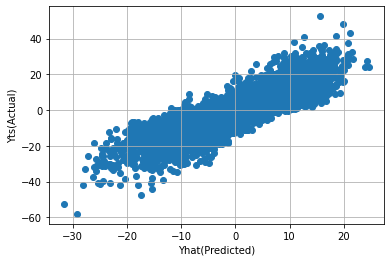

In [16]:
plt.scatter(yhattsdly,ytsdly)
plt.xlabel("Yhat(Predicted)")
plt.ylabel("Yts(Actual)")
plt.grid(True)

## Selecting the Optimal Delay via Model Order Selection

In the previous example, we fixed `d=6`.  We can now select the optimal delay using model order selection.  Since we have a large number of data samples, it turns out that the optimal model order uses a very high delay.  
So to save on computation time, we will just do a simple train-test split. We won't do any k-fold cross-validation. 

We will look at model orders up to `dmax=30`.  Create a delayed dataset, `Xdly,ydly` using `create_dly_data` with `dly=dmax`. Split this data into training and test data as before, with a 2/3 -1/3 split.

In [21]:
dmax = 30

Xdly30, ydly30 = create_dly_data(X,y,dmax)
Xtrdly30,ytrdly30,Xtsdly30,ytsdly30 = splitIntoTrainAndTest(Xdly30,ydly30)
betaDly30 = performCalculation(createMatrix(Xtrdly30),ytrdly30)
yhattsdly30 = createMatrix(Xtsdly30).dot(betaDly30)
loss = np.sum((yhattsdly30-ytsdly30)**2)/len(ytsdly30)
print(f"Loss for (d = dmax = 30) = {loss} ")

Loss for (d = dmax = 30) = 16.689187052025847 


Implement a loop to test different amounts of delay from 0 to `dmax`. For each delay, you should train on the train set and compute the average squared loss on the test set. Store these losses in an array `losses`.

Note that for different delay values you should be using a different **subset of columns** from the `Xdly` matrix you just created. To save time, you don't want to be re-creating a new test set for each model order you experiment with.

**Note:** This could take a long time (several minutes) to run! This is a large data set and we are using many features in our multivariate regression. You might want to test/debug your code with a signficantly small value of `dmax` before doing a final run.

In [22]:
losses = np.zeros(dmax)
for i in range(0,dmax):
    Xdlyi, ydlyi = create_dly_data(X,y,i)
    Xtrdlyi,ytrdlyi,Xtsdlyi,ytsdlyi = splitIntoTrainAndTest(Xdlyi,ydlyi)
    betaDlyi = performCalculation(createMatrix(Xtrdlyi),ytrdlyi)
    yhattsdlyi = createMatrix(Xtsdlyi).dot(betaDlyi)
    losses[i] = np.sum((yhattsdlyi-ytsdlyi)**2)/len(ytsdlyi)
    print(f"d = {i} : loss = {losses[i]}")

d = 0 : loss = 31.606247495492646
d = 1 : loss = 25.537486147981788
d = 2 : loss = 22.557880703539215
d = 3 : loss = 20.54674808464817
d = 4 : loss = 18.796903923257247
d = 5 : loss = 17.985173408458195
d = 6 : loss = 17.71261771547103
d = 7 : loss = 16.97634631215737
d = 8 : loss = 16.522154236746456
d = 9 : loss = 16.4980166666718
d = 10 : loss = 16.365293992210525
d = 11 : loss = 16.355816233544623
d = 12 : loss = 16.325283162491555
d = 13 : loss = 16.361771092540607
d = 14 : loss = 16.736234661585645
d = 15 : loss = 16.30812628766669
d = 16 : loss = 15.997157810161555
d = 17 : loss = 16.369903963302278
d = 18 : loss = 15.91525956601118
d = 19 : loss = 16.193567943490542
d = 20 : loss = 16.442354069004903
d = 21 : loss = 16.490787431536223
d = 22 : loss = 16.534519695178542
d = 23 : loss = 16.399037698997766
d = 24 : loss = 16.197259746588283
d = 25 : loss = 16.24664997514882
d = 26 : loss = 16.25471022789397
d = 27 : loss = 16.338948708713428
d = 28 : loss = 16.01783090945604
d = 2

Which amount of delay lead to the best model fit? Plot losses as a function of `range(0,dmax)` to visualize how generalization of your model changes with increasing complexity

Minimum loss of 15.91525956601118 happens when d = 18


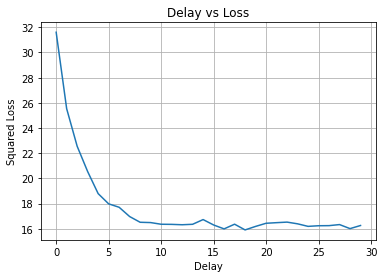

In [25]:
best_d, best_loss=np.argmin(losses),np.min(losses)
print(f"Minimum loss of {best_loss} happens when d = {best_d}")
plt.plot(range(0,dmax),losses)
plt.xlabel("Delay")
plt.ylabel("Squared Loss")
plt.title("Delay vs Loss")
plt.grid(True)